## Galaxy Image Deconvolution

In this notebook, we will play with a prevalent task in astronomical image processing - **image deconvolution**. Due to the nonideal effects of the atmosphere and telescope optics, images captured by telescopes suffer from blurs, which are characterized by the [**point spread function (PSF)**](https://en.wikipedia.org/wiki/Point_spread_function) of the telescope. Removing those blurs is crucial for astronomers to uncover knowledge of the universe precisely. Since the blurring effect can be mathematically modeled by a 2D [convolution](https://en.wikipedia.org/wiki/Convolution) with the PSF, removing those blurs is called [**deconvolution**](https://en.wikipedia.org/wiki/Deconvolution).

### Preparations

Download and import the required packages.

In [ ]:
# %pip install numpy matplotlib scikit-image

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

Download the files we need in this project.

In [ ]:
!wget https://raw.githubusercontent.com/Lukeli0425/Galaxy-Deconv/main/tutorials/galaxy.npy
!wget https://raw.githubusercontent.com/Lukeli0425/Galaxy-Deconv/main/tutorials/psf.npy

--2024-06-25 16:21:30--  https://raw.githubusercontent.com/Lukeli0425/Galaxy-Deconv/main/tutorials/galaxy.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9344 (9.1K) [application/octet-stream]
Saving to: ‘galaxy.npy.1’

galaxy.npy.1        100%[===================>]   9.12K  --.-KB/s    in 0s      

2024-06-25 16:21:30 (79.4 MB/s) - ‘galaxy.npy.1’ saved [9344/9344]

--2024-06-25 16:21:30--  https://raw.githubusercontent.com/Lukeli0425/Galaxy-Deconv/main/tutorials/psf.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9344 (9.

Load the _clean_ galaxy image (without blur and noise) and the point spread function (PSF) of the telescope. For simplicity, these images are provided for you. If you want to learn more about how to simulate these images, check out [this notebook](https://github.com/Lukeli0425/Galaxy-Deconv/blob/main/tutorials/image_simulation.ipynb).

In [ ]:
galaxy = np.load('galaxy.npy')
psf = np.load('psf.npy')

# Normalize to a flux of 1.
galaxy = galaxy / galaxy.sum()
psf = psf / psf.sum()

Now let's take a look at the galaxy and the PSF. They are all 48*48 images with a total flux of 1.

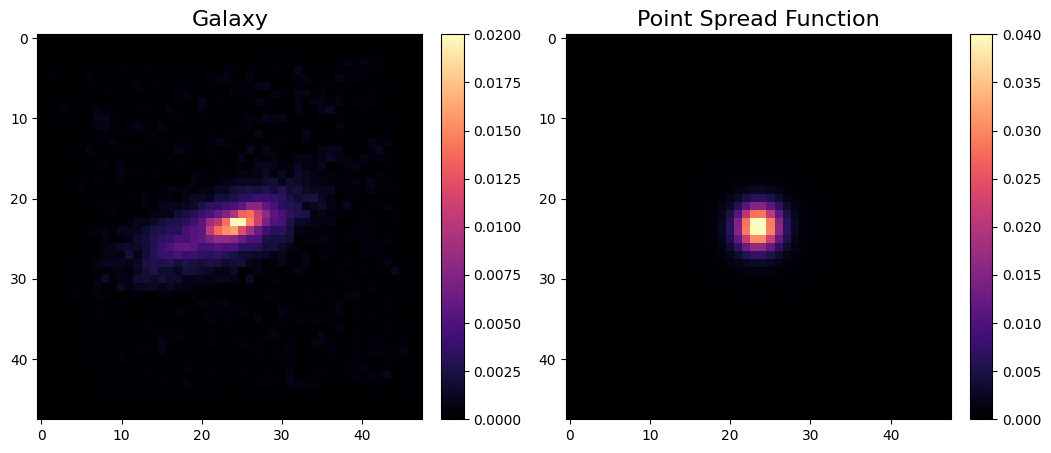

In [ ]:
fig = plt.figure(figsize=(12.5, 5))
ax = plt.subplot(1, 2, 1)
norm = Normalize(vmin=0, vmax=0.02)
plt.imshow(galaxy, cmap='magma', norm=norm)
plt.title('Galaxy', fontsize=16)
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.018, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)

ax = plt.subplot(1, 2, 2)
norm = Normalize(vmin=0, vmax=0.04)
plt.imshow(psf, cmap='magma', norm=norm)
plt.title('Point Spread Function', fontsize=16)
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.018, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)

### Forward Model

In this part, we will simulate the imaging forward model of the telescope. In other words, we will generate galaxy images after collected by the telescope optics and the sensor. Usually, we assume the PSF has very little change across a very small image patch, so we treat the PSF to be _shift invariant_ in the images.

To efficiently conduct convolution and deconvolution, the common practice is to transform both the images and the PSF to the Fourier space using [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform). Throughout this notebook, all FFTs are already written for you. The `convolve()` function below performs 2D convolution using FFT. You don't need to change it.

In [ ]:
def pad_double(img):
    """Pad the image with zeros to double its size.

    Args:
        img (`np.ndarray`): Input image.

    Returns:
        `np.ndarray`: Padded image.
    """
    H, W = img.shape[-2], img.shape[-1]
    return np.pad(img, ((W//2, W//2), (H//2, H//2)), 'constant', constant_values=(0, 0))

def crop_half(img):
    """Crop the image to half of its size.

    Args:
        img (`np.ndarray`): Input image.

    Returns:
        `np.ndarray`: Cropped image.
    """
    H, W = img.shape
    return img[H//4:3*H//4, W//4:3*W//4]

def convolve(x, h):
    """Convolve two 2D images using FFT.

    Args:
        x (`np.ndarray`): Input image 1.
        h (`np.ndarray`): Input image 2.

    Returns:
        `np.ndarray`: Convolved image.
    """
    h, x = pad_double(h), pad_double(x)
    y = fftshift(ifft2(fft2(ifftshift(h)) * fft2(ifftshift(x)))).real
    return crop_half(y)

The first step is to calculate the noise level and add the right amount of noise to the image. To do so, let's first define some telescope and CCD parameters. These parameters are chosen from an upcoming sky survey, the [Legacy Survey of Space and Time (LSST)](https://rubinobservatory.org). The facility used in this survey is the _Vera C. Rubin Observatory_ in Northern Chile. Since this is a ground-based survey, there are both optical and atmospheric components in the PSF.

In [ ]:
pixel_scale = 0.2                   # Pixel scale (aresec), determines the image resolution.
exp_time = 30.                      # Exposure time (2*15 seconds).
sky_brightness = 20.46              # Sky brightness (absolute magnitude) in i band.
zero_point = 28.17                  # Instrumental zero point in i band, i.e. absolute magnitude that would produce one e- per second.
qe = 0.94                           # CCD Quantum efficiency.
read_noise = 8.8                    # Standrad deviation of Gaussain read noise (e-/pixel).
dark_current = 0.2                  # Dark current (e-/pixel/second).

The dominant component of CCD noise is the Poisson shot noise coming from the sky background. In this part, you will calculate the flux of the sky background using this relation
$\begin{equation}
    F = t_{exp} \cdot 10^{-0.4(M_{ab}-M_0)*\eta_{qe}},
\end{equation}$
where $t_{exp}$ is the exposure time, $M_{ab}$ is the [absolute magnitude](https://en.wikipedia.org/wiki/Absolute_magnitude) of the sky background, $M_0$ is the [zero point](https://en.wikipedia.org/wiki/Zero_point_(photometry)) of the instrument (the absolute magnitude that would produce one e- per second in the CCD), $\eta_{qe}$ is the [quantum efficiency](https://en.wikipedia.org/wiki/Quantum_efficiency) (the number of electrons produced by one photon) of the CCD.

__TODO 1: Complete the function `get_flux()`.__

In [ ]:
def get_flux(exp_time, ab_magnitude, zero_point, qe):
    """Calculate flux (e-/arcsec^2) from magnitude.

    Args:
        exp_time (`float`): Exposure time (s).
        ab_magnitude (`float`): Absolute magnitude.
        zero_point (`float`): Instrumental zero point, i.e. absolute magnitude that would produce one e- per second.
        qe (`float`): CCD Quantum efficiency.

    Returns:
        `float`: Flux (e-/arcsec^2).
    """
    ### TODO 1: Calculate flux. ###
    flux = exp_time * 10**(-0.4*(ab_magnitude-zero_point) * qe)
    return flux
    ### End TODO 1 ###

# Calculate the per pixel sky level (e-/pixel).
sky_level_pixel = (pixel_scale ** 2) * get_flux(ab_magnitude=sky_brightness, exp_time=exp_time, zero_point=zero_point, qe=qe)
print('Sky level per pixel: {:.5g} e-'.format(sky_level_pixel))

Sky level per pixel: 950.91 e-


In [ ]:
flux = get_flux(ab_magnitude=sky_brightness, exp_time=exp_time, zero_point=zero_point, qe=qe)
print(flux)

23772.850253153647


Now we scale the flux of the galaxy according to the desired SNRs. We follow the [signal-to-noise ratio (SNR)](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) definition in the [GREAT3 Challenge](https://iopscience.iop.org/article/10.1088/0067-0049/212/1/5/meta)
$\begin{equation}
SNR = \sqrt{\frac{\sum G(i,j)^2}{\sigma^2}},
\end{equation}$
where $\sigma^2$ is the variance of total noise at each pixel, G(i,j) is the light profile of the galaxy.

The variance $\sigma^2$ at each pixel is treated to be the same because the sky level is often high enough that its Poisson shot noise is essentially a Gaussian with a single constant variance and a mean of zero. The variance of total noise $\sigma^2$ is the sum of Poisson shot noise $I_0$ from the sky background, Poisson shot noise $I_d * t_{exp}$ from the dark current, and the Gaussian read noise $\sigma_r^2$.

$\begin{equation}
\sigma^2 = I_0 + I_d * t_{exp} + 2*\sigma_r^2.
\end{equation}$

There's a factor of 2 in front of the read noise $\sigma_r^2$ because LSST takes two 15s exposures instead of a single 30s exposure, i.e. there are two readouts in one image.

__TODO 2: Complete the function `get_total_noise()` using the relation above. You might need `np.sqrt()`.__

In [ ]:
def get_total_noise(sky_level_pixel, dark_current, exp_time, read_noise):
    """Calculate the noise in LSST images.

    Args:
        sky_level_pixel (`float`): Sky background level (e-/pixel).
        dark_current (`float`): Dark current (e-/pixel/second).
        exp_time (`float`): Total exposure time (s).
        read_noise (`float`): Standard deviation of CCD read noise (e-).

    Returns:
        `float`: Standard deviation of total noise (e-/pixel).
    """
    ### TODO 2: Calculate the noise in LSST images. ###
    noise = np.sqrt(sky_level_pixel + dark_current*exp_time + 2 * read_noise ** 2)
    return noise
    ### End TODO 2 ###

sigma = get_total_noise(sky_level_pixel, dark_current, exp_time, read_noise)
print('sigma: {:.4g} e-'.format(sigma))

sigma: 33.34 e-


Now, we can scale the galaxy images using the noise level we just obtained to make sure that the images we simulate have the desired SNR:
$\begin{equation}
 G(i,j) = G(i,j) \cdot \frac{SNR \cdot \sigma}{\sqrt{\sum G(i,j)^2}}.
\end{equation}$
Here, the scaling factor $\alpha = \frac{SNR \cdot \sigma}{\sqrt{\sum G(i,j)^2}}$.

Then, we can convolve the galaxy with the PSF and add noise to simulate the observed galaxy image:
$\begin{equation}
 y = G \ast h + n,  
\end{equation}$
where $y$ is the observed galaxy image, $\ast$ denotes 2D shift-invariant convolution, $h$ is the PSF, and $n$ is the total noise (treated as i.i.d. Gaussian).

__TODO 3: Calculate the scaling factor `alpha` using the relation given above. You might need `np.sum()` and `np.sqrt()`.__

__TODO 4: Convolve the galaxy image with PSF using the provided function `convolve()` and add Gaussian noise with zero mean and standard deviation of `sigma`.__

In [ ]:
snr_list = [60, 100, 200, 300]
obs_list, gt_list = [], []

for snr in snr_list:
    ### TODO 3: Calculate the scaling factor to meet SNR requirement. ###
    alpha = snr * sigma / np.sqrt(np.sum((galaxy**2)))
    ### End TODO 3 ###
    g = galaxy * alpha # Scale the flux of galaxy and covert to ADU.

    n = np.random.normal(0, sigma, g.shape) # Gaussian noise.
    ### TODO 4: Concolve the scaled galaxy image with the PSF and then add Gaussian noise. ###
    y = convolve(g, psf) + n
    ### End TODO 4 ###

    gt_list.append(g)
    obs_list.append(y)

### Fourier Transformations

To complete the following parts, you will need to perform Fourier transformations on multiple variables. Fortunately, you do not have to learn how to calculate these by hand when you have numpy to rescue you. Learn more about Numpy's discrete Fourier transform package `numpy.fft` here: https://numpy.org/doc/stable/reference/routines.fft.html. The functions you will need for this notebook will be included below.


#### Standard FFTs

Function | Description
:- | :-
fft(a[, n, axis, norm, out]) | Compute the one-dimensional discrete Fourier Transform
ifft(a[, n, axis, norm, out]) | Compute the one-dimensional discrete inverse Fourier Transform
fft2(a[, s, axis, norm, out]) | Compute the 2-dimensional discrete Fourier Transform
ifft2(a[, s, axis, norm, out]) | Compute the 2-dimensional discrete inverse Fourier Transform
fftn(a[, s, axis, norm, out]) | Compute the n-dimensional discrete Fourier Transform
ifftn(a[, s, axis, norm, out]) | Compute the n-dimensional discrete inverse Fourier Transform

#### Helper Routines

Function | Description
:- | :-
fftshift(x[, axes]) | Shift the zero-frequency component to the center of the spectrum
ifftshift(x[, axes]) | The inverse of fftshift

\
Our first example of these functions was in our definitions of the convolve function. Let's look at it again.

```python
 def convolve(x, h):
    """Convolve two 2D images using FFT.

    Args:
        x (`np.ndarray`): Input image 1.
        h (`np.ndarray`): Input image 2.

    Returns:
        `np.ndarray`: Convolved image.
    """
    h, x = pad_double(h), pad_double(x)
    y = fftshift(ifft2(fft2(ifftshift(h)) * fft2(ifftshift(x)))).real
    return crop_half(y)
```

That's a lot of f's and t' so let's break y down.


We'll call `fft2(ifftshift(h)) = H` and `fft2(ifftshift(x)) = X` where `H` and `X` are the 2D Fourier Transform of the inversely shifted h-array and x-array respectively.


Then, we have.

``` python
H = fft2(ifftshift(h))
X = fft2(ifftshift(x))

y = fftshift(ifft2(H * X)).real
```

Lastly, `y` includes only the REAL solutions of the shifted 2D inverse Fourier Transform of the product of `H` and `X`.

### Deconvolution

In the final part, you will implement two classic deconvolution methods to remove the blurs caused by PSFs. These methods are [Wiener Filtering ](https://en.wikipedia.org/wiki/Wiener_deconvolution) and [Richardson-Lucy](https://en.wikipedia.org/wiki/Richardson–Lucy_deconvolution), which are both widely used in astronomical image processing. You don't need to learn the two methods to complete this part, this notebook will guide you to implement them.

**[Wiener Filtering ](https://en.wikipedia.org/wiki/Wiener_deconvolution)** deconvolves the image by filtering in Fourier space:
$\begin{equation} X(f) = \frac{H^*(f) Y(f)}{\vert H(f)\vert^2 + \lambda}, \end{equation}$
where $Y(f), X(f), H(f)$ are the 2-D Fourier transform of the blurry image, clean image, and PSF, and $\lambda$ (lamda) is the regularization parameter.

__TODO 5: Complete the numerator and divisor calculations in `wiener()`. You might need `np.abs()`, `np.conj()`, `np.real()`, `fft2()`, `ifft2()`, `fftshift()`, and `ifftshift()`.__

In [ ]:
def wiener(y, h, lam):
    """Wiener Deconvolution.

    Args:
        y (`np.ndarray`): Input blurry image.
        h (`np.ndarray`): Blur kernel (point spread function).
        lamda  (`float`): Regularization parameter.
    """
    H = fft2(ifftshift(h)) # 2D Fourier Transform of the inversely shifted PSF array
    H_star = H.conj() # Complex conjugate of H
    Y = fft2(ifftshift(y)) # 2D Fourier Transform of the inversely shifted blurry image array

    ### TODO 5: Complete Wiener Deconvolution. ###
    numerator = H_star * Y
    divisor = np.abs(H)**2 + lamda
    ### End TODO 5 ###

    # x: Real solutions of the shifted 2D inverse Fourier Transform of numerator/divisor
    x = fftshift(ifft2(numerator/divisor)).real
    return x

Visualize the deconvolution results with different values of regularization parameter $\lambda$. You can also quantitatively compare the image qualities, using two metrics: the [peak signal-to-noise ratio (PSNR)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) and the [structural similarity index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity_index_measure). This part is implemented for you.

/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


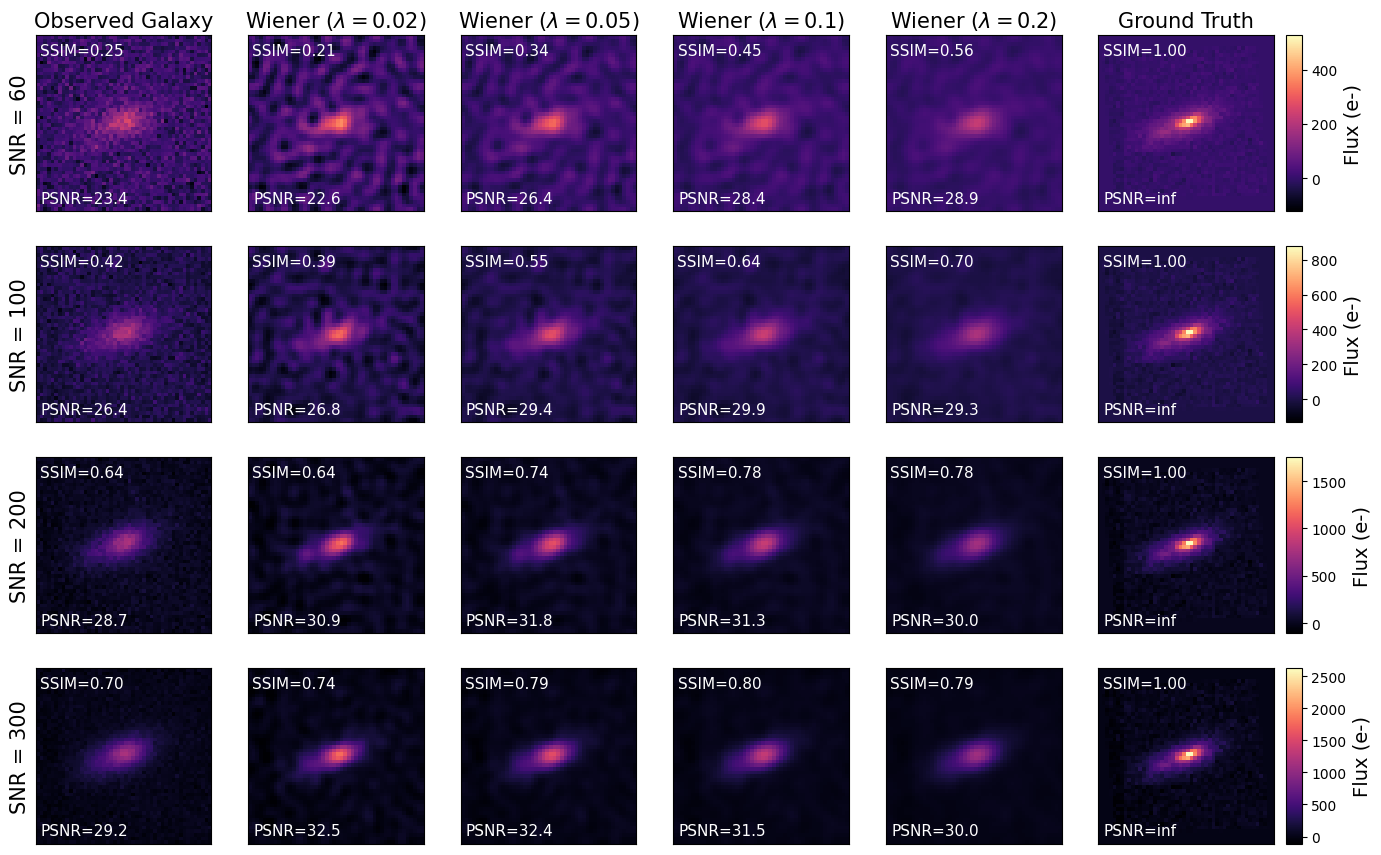

In [ ]:
lam_list = [0.02, 0.05, 0.1, 0.2] # Change to compare different regularization parameters.

fig = plt.figure(figsize=(16, 10.5))
for idx, (x, y, snr) in enumerate(zip(gt_list, obs_list, snr_list)):
    norm = Normalize(vmin=y.min(), vmax=x.max())
    ax1 = plt.subplot(4,6,6*idx+1)
    plt.imshow(y, cmap='magma', norm=norm)
    plt.ylabel(f'SNR = {snr}', fontsize=15)
    ax1.set_xticks([])
    ax1.set_yticks([])
    plt.title('PSNR={:.1f}'.format(psnr(x, y, data_range=x.max()-x.min())), fontsize=11, loc='left', x=0.03, y=0.0, color='white')
    plt.title('SSIM={:.2f}'.format(ssim(x, y, data_range=x.max()-x.min())), fontsize=11, loc='right', x=0.5, y=0.84, color='white')
    if idx == 0:
        plt.title('Observed Galaxy', fontsize=15)


    for i, lam in enumerate(lam_list):
        x_star = wiener(y, psf, lam)
        ax2 = plt.subplot(4,6,6*idx+i+2)
        plt.imshow(wiener(y, psf, lam), cmap='magma', norm=norm)
        ax2.set_xticks([])
        ax2.set_yticks([])
        plt.title('PSNR={:.1f}'.format(psnr(x, x_star, data_range=x.max()-x.min())), fontsize=11, loc='left', x=0.03, y=0.0, color='white')
        plt.title('SSIM={:.2f}'.format(ssim(x, x_star, data_range=x.max()-x.min())), fontsize=11, loc='right', x=0.5, y=0.84, color='white')
        if idx == 0:
            plt.title('Wiener ($\lambda=${:.1g})'.format(lam), fontsize=15)


    ax4 = plt.subplot(4,6,6*idx+6)
    plt.imshow(x, cmap='magma', norm=norm)
    plt.title('PSNR={:.1f}'.format(psnr(x, x, data_range=x.max()-x.min())), fontsize=11, loc='left', x=0.03, y=0.0, color='white')
    plt.title('SSIM={:.2f}'.format(ssim(x, x, data_range=x.max()-x.min())), fontsize=11, loc='right', x=0.5, y=0.84, color='white')
    if idx == 0:
        plt.title('Ground Truth', fontsize=15)
    cax = fig.add_axes([ax2.get_position().x1+0.14, ax2.get_position().y0, 0.01, ax2.get_position().height])
    cb = plt.colorbar(cax=cax, norm=norm)
    cb.set_label('Flux (e-)', fontsize=14)
    ax4.set_xticks([])
    ax4.set_yticks([])

[**Richardson-Lucy**](https://en.wikipedia.org/wiki/Richardson–Lucy_deconvolution) is an iterative algorithm that solves deconvolution problems under Poisson noise models. First, we initialize the solution with a non-negative image, for example, an all-one image:

$\begin{equation}
\mathbf{x}^0 = \mathbf{1}.
\end{equation}$

Then, we iteratively update $\mathbf{x}$ using the following equation:
$\begin{equation}
\mathbf{x}^{k+1} = \mathbf{x}^{k} \cdot \frac{H^T \frac{\mathbf{y}}{H\mathbf{x^k}}}{H^T \mathbf{1}}.
\end{equation}$

__TODO 6: Read the code below and complete the Richardson-Lucy update step in `richardson_lucy()`.__

In [ ]:
def richardson_lucy(y, h, sky_level_pixel, n_iter):
    """Richardson-Lucy Deconvolution.

    Args:
        y (`np.ndarray`): Input blurry image.
        h (`np.ndarray`): Blur kernel (point spread function).
        sky_level_pixel (`float`): Sky level (e-/pixel).
        n_iter (`int`): Number of iterations.
    """
    y = y + sky_level_pixel # Add the sky level.
    ones = np.ones_like(y) # All-one image.
    H = fft2(ifftshift(h)) # 2D Fourier Transform of the PSF.
    x = np.ones_like(y) # Initial guess.
    for _ in range(n_iter):
        X = fft2(ifftshift(x))
        Hx = fftshift(ifft2(H * X)).real

        H_star = H.conj() # Complex conjugate of H
        yHx = fft2(ifftshift(y/Hx)) # 2D Fourier Transform of the inversely shifted y/Hx
        # numerator: Real solutions of the shifted 2D inverse Fourier Transform of the product H_star and yHx
        numerator = fftshift(ifft2(H_star * yHx)).real

        onesx = fft2(ifftshift(ones)) # 2D Fourier Transform of the inversely shifted ones array
        # divisor: Real solutions of the shifted 2D inverse Fourier Transform of the product H_star and onesx
        divisor = fftshift(ifft2(H_star * onesx)).real

        ### TODO 6: Complete Richardson-Lucy update. ###
        x = x * numerator / divisor
        ### End TODO 6 ###
    return x - sky_level_pixel  # Subtract the sky level.

Visualize the deconvolution results with different iteration count `n_iter`. You can also quantitatively compare the image qualities, using two metrics: the [peak signal-to-noise ratio (PSNR)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) and the [structural similarity index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity_index_measure). This part is implemented for you.

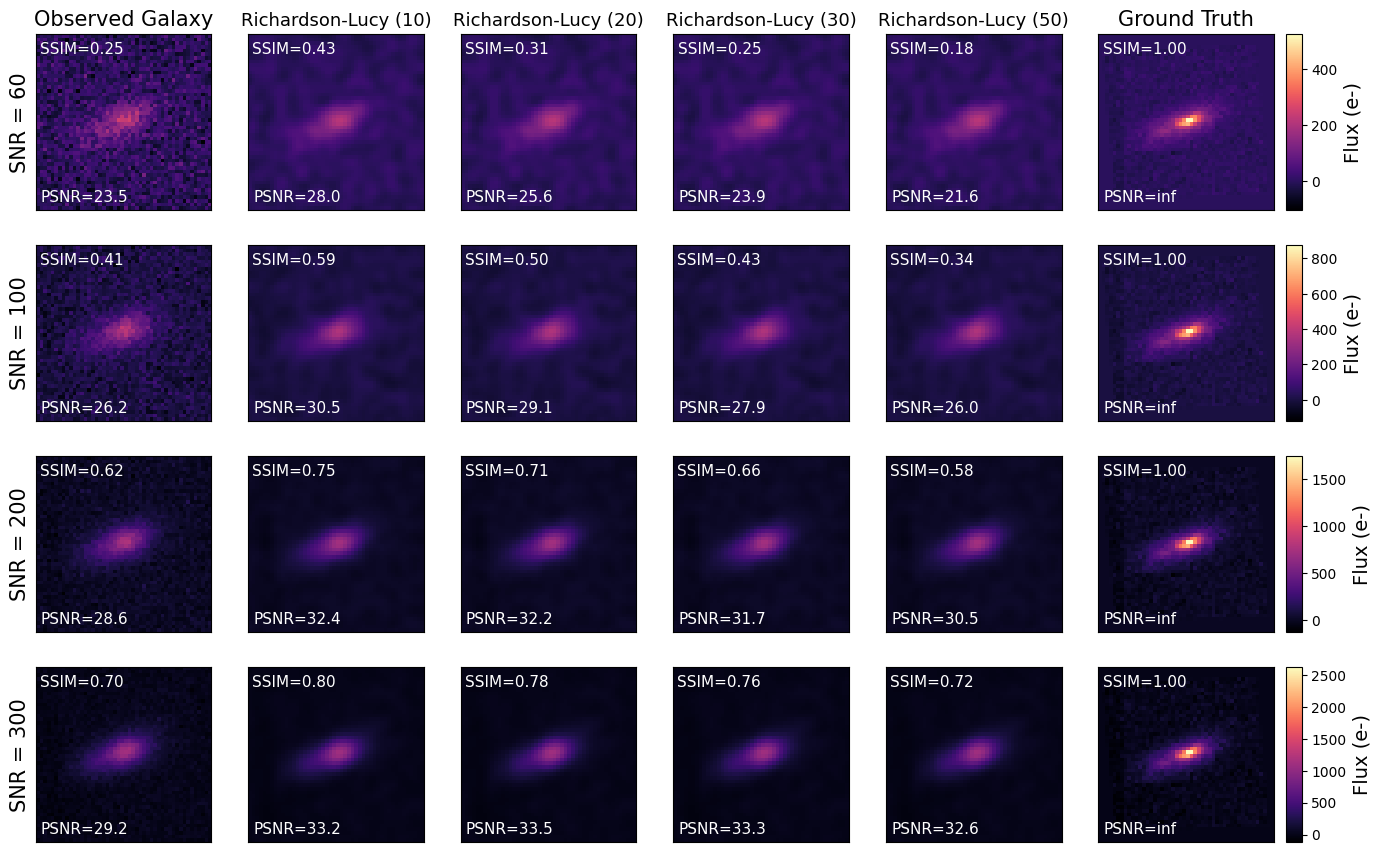

In [ ]:
iters_list = [10, 20, 30, 50] # Change to compare different iteration counts.

fig = plt.figure(figsize=(16, 10.5))
for idx, (x, y, snr) in enumerate(zip(gt_list, obs_list, snr_list)):
    norm = Normalize(vmin=y.min(), vmax=x.max())
    ax1 = plt.subplot(4,6,6*idx+1)
    plt.imshow(y, cmap='magma', norm=norm)
    plt.ylabel(f'SNR = {snr}', fontsize=15)
    ax1.set_xticks([])
    ax1.set_yticks([])
    plt.title('PSNR={:.1f}'.format(psnr(x, y, data_range=x.max()-x.min())), fontsize=11, loc='left', x=0.03, y=0.0, color='white')
    plt.title('SSIM={:.2f}'.format(ssim(x, y, data_range=x.max()-x.min())), fontsize=11, loc='right', x=0.5, y=0.84, color='white')
    if idx == 0:
        plt.title('Observed Galaxy', fontsize=15)


    for i, n_iters in enumerate(iters_list):
        x_star = richardson_lucy(y, psf, sky_level_pixel, n_iters)
        ax2 = plt.subplot(4,6,6*idx+i+2)
        plt.imshow(wiener(y, psf, lam), cmap='magma', norm=norm)
        ax2.set_xticks([])
        ax2.set_yticks([])
        plt.title('PSNR={:.1f}'.format(psnr(x, x_star, data_range=x.max()-x.min())), fontsize=11, loc='left', x=0.03, y=0.0, color='white')
        plt.title('SSIM={:.2f}'.format(ssim(x, x_star, data_range=x.max()-x.min())), fontsize=11, loc='right', x=0.5, y=0.84, color='white')
        if idx == 0:
            plt.title(f'Richardson-Lucy ({n_iters})', fontsize=13)


    ax4 = plt.subplot(4,6,6*idx+6)
    plt.imshow(x, cmap='magma', norm=norm)
    plt.title('PSNR={:.1f}'.format(psnr(x, x, data_range=x.max()-x.min())), fontsize=11, loc='left', x=0.03, y=0.0, color='white')
    plt.title('SSIM={:.2f}'.format(ssim(x, x, data_range=x.max()-x.min())), fontsize=11, loc='right', x=0.5, y=0.84, color='white')
    if idx == 0:
        plt.title('Ground Truth', fontsize=15)
    cax = fig.add_axes([ax2.get_position().x1+0.14, ax2.get_position().y0, 0.01, ax2.get_position().height])
    cb = plt.colorbar(cax=cax, norm=norm)
    cb.set_label('Flux (e-)', fontsize=14)
    ax4.set_xticks([])
    ax4.set_yticks([])

You can play with the parameters used in both methods to see how they impact the qualities of deconvolve images. Briefly write down your findings here:

**[Your Answer Here]**